## Multi Class Image Classification using Tensorflow-Keras

**Author: Abhishek Dey**

### Import Libraries

In [1]:
import os
import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing import image

from sklearn.metrics import confusion_matrix, classification_report

2025-09-04 16:20:21.065129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757002821.268701      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757002821.334020      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Set Hyperparameters


In [2]:
image_size=(150,150)
input_shape = (150, 150, 3)
num_classes = 6
batch_size=64
epochs = 100
patience = 15
train_data_path="/kaggle/input/intel-image-classification/seg_train/seg_train"
test_data_path="/kaggle/input/intel-image-classification/seg_test/seg_test"

### Load Training data and train-val split

In [3]:

train_ds, val_ds = keras.utils.image_dataset_from_directory(

    train_data_path,
    subset="both",
    validation_split=0.2,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=42,

)


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Using 2806 files for validation.


I0000 00:00:1757003598.110153      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


### Load Test data

In [4]:

test_ds = keras.utils.image_dataset_from_directory(

    test_data_path,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,

)

Found 3000 files belonging to 6 classes.


### Get Class Names

In [5]:
class_names = sorted([d for d in os.listdir(train_data_path) if os.path.isdir(os.path.join(train_data_path, d))])
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### Visualize sample data

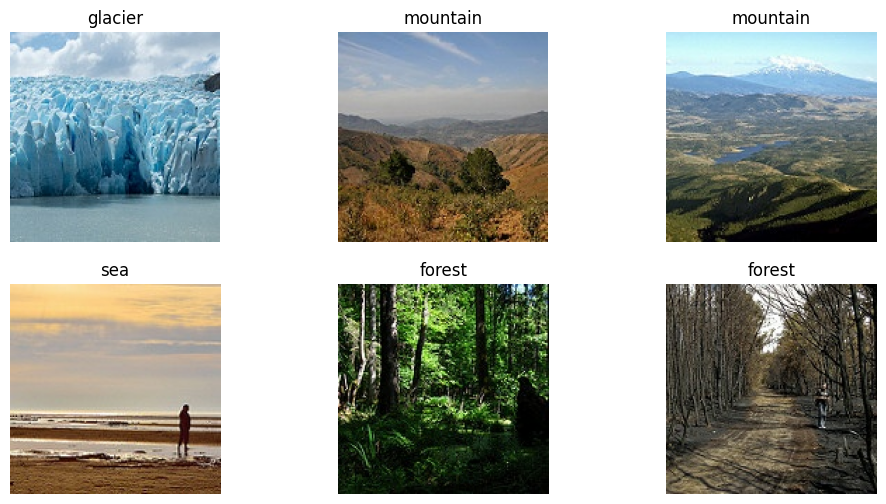

In [6]:
#sample_data=train_ds
#sample_data=val_ds
sample_data=test_ds

plt.figure(figsize=(12, 6))
for images, labels in sample_data.take(1):
    for i in range(6):
        ax = plt.subplot(2,3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_names[int(labels[i])]) 
        plt.axis("off")

### Data Augmentation

In [7]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images
    layers.RandomRotation(0.3),                    # Rotate images by ±30%
    layers.RandomZoom(0.2),                        # Zoom in/out
    layers.RandomContrast(0.2),                    # Adjust contrast
    layers.RandomBrightness(factor=0.2),           # Adjust brightness (TF >= 2.13)
])

### Data Normalisation

In [8]:
normalization = layers.Rescaling(1./255)

### Model Architecture

In [9]:


model = Sequential([
    layers.Input(shape=input_shape),

    data_augmentation,                # Data augmentation (train only)
    normalization,        # Normalize pixels

    # 1st Conv block
    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2)),


    # 2nd Conv block
    Conv2D(128, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2)),

    # 3rd Conv block
    Conv2D(256, (3,3), activation='relu', padding='same'),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2)),


    # 4th Conv block
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2)),
    
    # Flatten before feeding into Dense layers
    Flatten(),
    

    # Fully connected layer-1
    Dense(512, activation='relu'),
    Dropout(0.5),

    # Fully connected layer-2
    Dense(512, activation='relu'),
    Dropout(0.5),


    # Output
    Dense(num_classes, activation='softmax')
])


### Model Plot

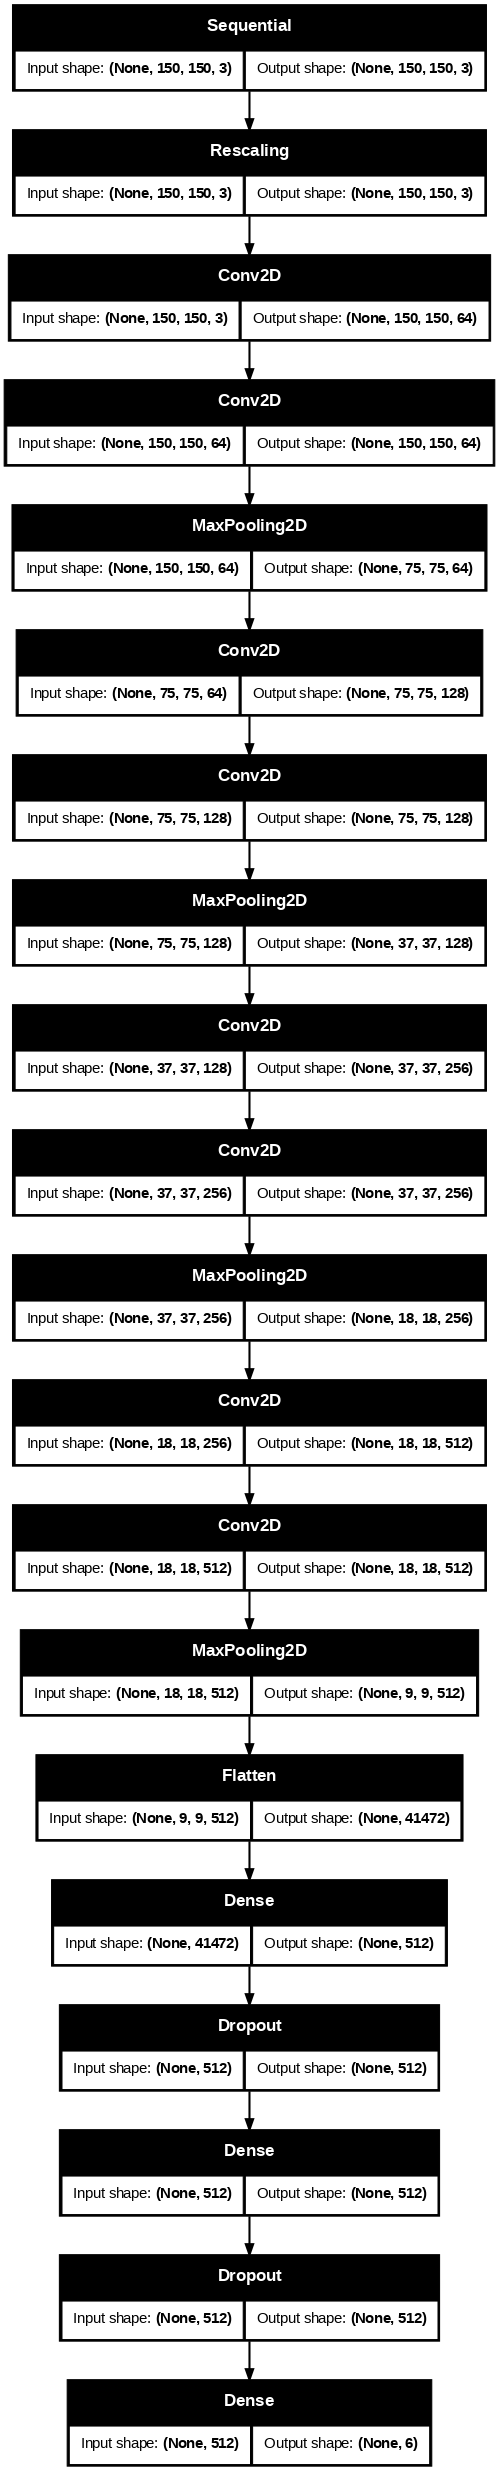

In [10]:
keras.utils.plot_model(model, show_shapes=True, dpi=75)

### Model Summary

In [11]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,185,286 (99.89 MB)

 Trainable params: 26,185,286 (99.89 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [12]:
checkpoint = ModelCheckpoint(
    filepath="/kaggle/working/best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=patience,           
    restore_best_weights=True,
    verbose=1
)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100


I0000 00:00:1757003925.529622     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.2643 - loss: 1.6703
Epoch 1: val_accuracy improved from -inf to 0.42552, saving model to /kaggle/working/best_model.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 53s 215ms/step - accuracy: 0.2647 - loss: 1.6696 - val_accuracy: 0.4255 - val_loss: 1.3277
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.4325 - loss: 1.3831
Epoch 2: val_accuracy improved from 0.42552 to 0.46151, saving model to /kaggle/working/best_model.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 33s 185ms/step - accuracy: 0.4326 - loss: 1.3828 - val_accuracy: 0.4615 - val_loss: 1.3341
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.4831 - loss: 1.2397
Epoch 3: val_accuracy improved from 0.46151 to 0.48717, saving model to /kaggle/working/best_model.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 33s 185ms/step - accuracy: 0.4832 - loss: 1.2397 - val_accuracy: 0.4872 - val_loss: 1.2865
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5140

### Accuracy and Loss plots

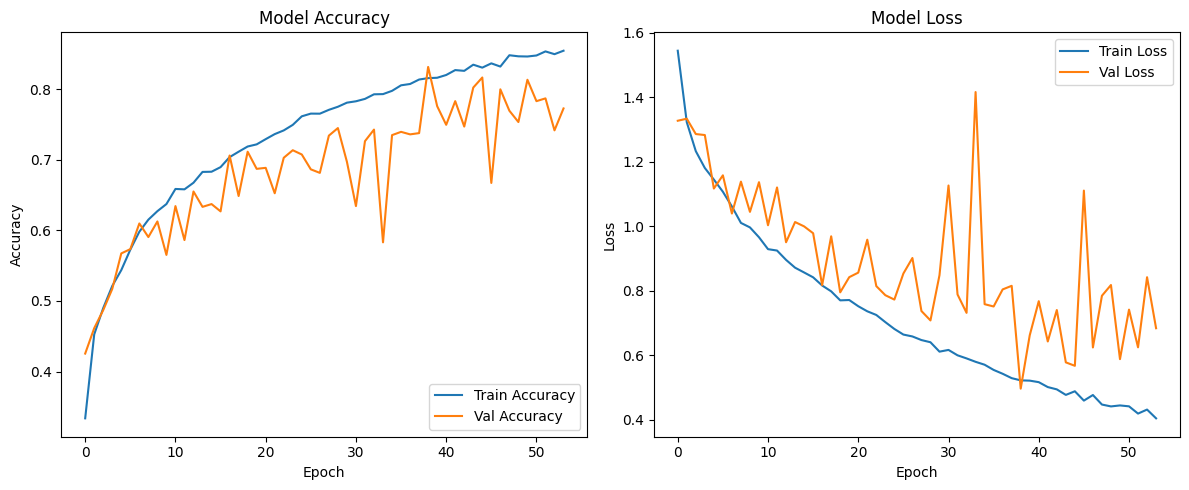

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


## Load Trained Model

In [14]:
trained_model = load_model('/kaggle/working/best_model.keras')

In [15]:
trained_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,555,860 (299.67 MB)

 Trainable params: 26,185,286 (99.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,370,574 (199.78 MB)

### Evaluation on Train, Val and Test sets

In [16]:
train_loss, train_acc = trained_model.evaluate(train_ds, verbose=1)
val_loss, val_acc = trained_model.evaluate(val_ds, verbose=1)
test_loss, test_acc = trained_model.evaluate(test_ds, verbose=1)


print("=========================================")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("=========================================")

print(f"Train Loss: {train_loss:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")


176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8429 - loss: 0.4360
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8294 - loss: 0.5031
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.8339 - loss: 0.4836
Train Accuracy: 0.8455
Val Accuracy: 0.8314
Test Accuracy: 0.8270
Train Loss: 0.4330
Val Loss: 0.4970
Test Loss: 0.5051


### Confusion Matrix on test set

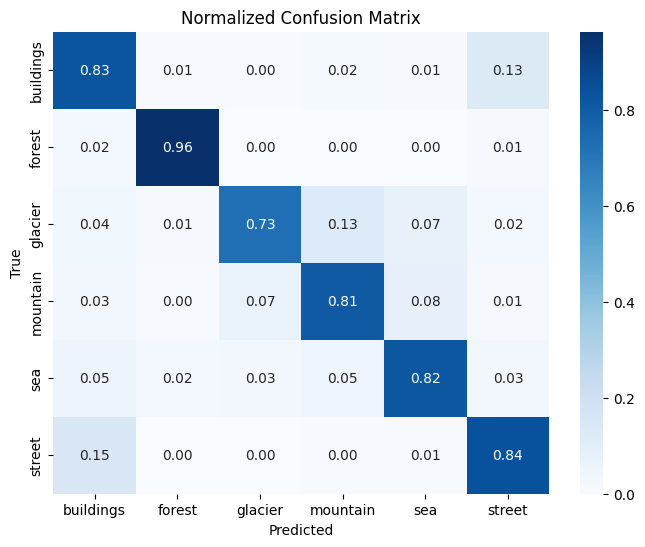

              precision    recall  f1-score   support

   buildings       0.71      0.83      0.76       437
      forest       0.95      0.96      0.96       474
     glacier       0.88      0.73      0.80       553
    mountain       0.80      0.81      0.80       525
         sea       0.82      0.82      0.82       510
      street       0.81      0.84      0.83       501

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



In [17]:
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())                       # true labels
    preds = trained_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))            # predicted labels

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Class names
class_names = test_ds.class_names

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

### Prediction on Unseen Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
Predicted class: forest


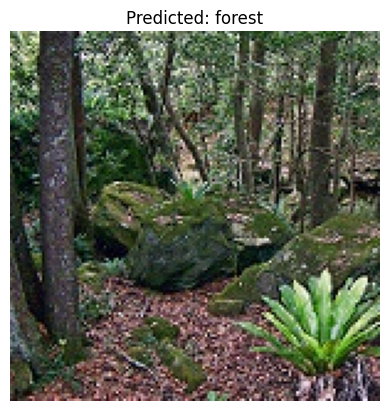

In [18]:
# Load model
trained_model = load_model("/kaggle/working/best_model.keras")

# Class names (same order as training folders)
class_names = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

# Load and preprocess image
#img_path = "/kaggle/input/intel-image-classification/seg_test/seg_test/buildings/20057.jpg"

img_path = "/kaggle/input/intel-image-classification/seg_pred/seg_pred/10092.jpg"

img = image.load_img(img_path, target_size=(150, 150), color_mode='rgb')  # must match training
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred_probs = trained_model.predict(img_array)
pred_class = np.argmax(pred_probs, axis=1)[0]
class_name = class_names[pred_class]

print(f"Predicted class: {class_name}")

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_name}")
plt.show()


### Keras to ONNX Conversion

In [33]:
keras_model_path="/kaggle/working/best_model.keras"
onnx_model_path="/kaggle/working/best_model.onnx"


model = load_model(keras_model_path)

# Run a dummy forward pass (forces "build")
dummy_input = np.random.rand(1, 150, 150, 3).astype(np.float32)
_ = model(dummy_input)

model.export(onnx_model_path, format="onnx")

I0000 00:00:1757009975.843611      36 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1757009975.843790      36 single_machine.cc:361] Starting new session
I0000 00:00:1757009975.845017      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1757009977.485941      36 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1757009977.486111      36 single_machine.cc:361] Starting new session
I0000 00:00:1757009977.487211      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1757009977.857548      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 wi